In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from tqdm import tqdm
import os
import random
import ipywidgets as widgets
import warnings
import json
import gc
import cv2
from collections import defaultdict

In [16]:
# !rm -rf /kaggle/working/*

In [17]:
class CFG:
    train_path = "/kaggle/input/MABe-mouse-behavior-detection/train.csv"
    test_path = "/kaggle/input/MABe-mouse-behavior-detection/test.csv"
    sample_submission_path = "/kaggle/input/MABe-mouse-behavior-detection/sample_submission.csv"
    train_annotation_path = "/kaggle/input/MABe-mouse-behavior-detection/train_annotation"
    train_tracking_path = "/kaggle/input/MABe-mouse-behavior-detection/train_tracking"
    test_tracking_path = "/kaggle/input/MABe-mouse-behavior-detection/test_tracking"
    output_path = "/kaggle/working/tracking_video"

    num_frames = 1000

In [18]:
train_df = pd.read_csv(CFG.train_path)

In [19]:
"""
Remove MABe labs (missing)
Count mice in per frame
"""
print(f"Original: {train_df.shape}")

# Remove 'MABe22_keypoints', 'MABe22_movies' from train data
remove_list = ["MABe22_keypoints", "MABe22_movies"]
train_without_mabe_df = train_df[~train_df["lab_id"].isin(remove_list)].copy()

# count mice in one frame (4 is MAX)
train_without_mabe_df['n_mice'] = 4 - train_without_mabe_df[['mouse1_strain', 'mouse2_strain', 'mouse3_strain', 'mouse4_strain']].isna().sum(axis=1).copy()

print(f"After removing MABe labs: {train_without_mabe_df.shape}")

Original: (8789, 38)
After removing MABe labs: (863, 39)


In [20]:
"""
Get 1 sample from each lab 
"""
tracking_samples_df = train_without_mabe_df.groupby("lab_id").head(1)
tracking_samples_df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,lab_id,video_id,mouse1_strain,mouse1_color,mouse1_sex,mouse1_id,mouse1_age,mouse1_condition,mouse2_strain,mouse2_color,...,video_width_pix,video_height_pix,arena_width_cm,arena_height_cm,arena_shape,arena_type,body_parts_tracked,behaviors_labeled,tracking_method,n_mice
0,AdaptableSnail,44566106,CD-1 (ICR),white,male,10.0,8-12 weeks,wireless device,CD-1 (ICR),white,...,1228,1068,60.0,60.0,square,familiar,"[""body_center"", ""ear_left"", ""ear_right"", ""head...","[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta...",DeepLabCut,4
17,BoisterousParrot,402963089,C57Bl/6N,black,female,6.0,7-14 weeks,NaN,C57Bl/6N,black,...,300,300,45.0,45.0,square,neutral,"[""body_center"", ""ear_left"", ""ear_right"", ""nose...","[""mouse1,mouse2,shepherd"", ""mouse2,mouse1,shep...",DeepLabCut,2
25,CRIM13,363958890,C57Bl/6J,black,male,3.0,NaN,NaN,BALB/c,white,...,640,480,35.0,15.0,rectangular,resident-intruder,"[""ear_left"", ""ear_right"", ""hip_left"", ""hip_rig...","[""mouse1,mouse2,approach"", ""mouse1,mouse2,atta...",MARS,2
46,CalMS21_supplemental,17308182,C57Bl/6J,black,male,55.0,NaN,NaN,BALB/c,white,...,1024,570,35.0,15.0,rectangular,resident-intruder,"[""ear_left"", ""ear_right"", ""hip_left"", ""hip_rig...","[""mouse1,mouse2,attack"", ""mouse1,mouse2,sniff""...",MARS,2
343,CalMS21_task1,13638642,C57Bl/6J,black,male,5.0,NaN,cabled device,BALB/c,white,...,1024,570,35.0,15.0,rectangular,resident-intruder,"[""ear_left"", ""ear_right"", ""hip_left"", ""hip_rig...","[""mouse1,mouse2,approach"", ""mouse1,mouse2,moun...",MARS,2
444,CalMS21_task2,26836610,C57Bl/6J,black,male,2.0,NaN,NaN,BALB/c,white,...,1024,570,35.0,15.0,rectangular,resident-intruder,"[""ear_left"", ""ear_right"", ""hip_left"", ""hip_rig...","[""mouse1,mouse2,attack"", ""mouse1,mouse2,mount""...",MARS,2
520,CautiousGiraffe,21954203,C57Bl/6J,black,female,4.0,NaN,NaN,C57Bl/6J,black,...,600,600,30.0,30.0,square,neutral,"[""ear_left"", ""ear_right"", ""hip_left"", ""hip_rig...","[""mouse1,mouse2,approach"", ""mouse1,mouse2,chas...",DeepLabCut,2
530,DeliriousFly,246051591,C57Bl/6J,black,male,5.0,NaN,cabled device,BALB/c,white,...,864,412,38.0,18.5,rectangular,resident-intruder,"[""body_center"", ""ear_left"", ""ear_right"", ""late...","[""'mouse1','mouse2','sniff'"", ""mouse1','mouse2...",DeepLabCut,2
536,ElegantMink,277941336,C57Bl/6J,black,male,49.0,NaN,NaN,129/SvEvTac,brown,...,720,480,33.0,16.0,rectangular,resident-intruder,"[""ear_left"", ""ear_right"", ""hip_left"", ""hip_rig...","[""mouse1,mouse2,attack"", ""mouse1,mouse2,introm...",SLEAP,2
555,GroovyShrew,1550138,C57Bl/6J,black,male,13.0,NaN,wireless device,C57Bl/6J,black,...,527,314,33.0,19.0,rectangular,neutral,"[""ear_left"", ""ear_right"", ""head"", ""tail_base""]","[""mouse1,mouse2,intromit"", ""mouse1,mouse2,moun...",SLEAP,2


In [21]:
# import numpy as np

# def clean_outliers_by_median(pvid, max_mouse=4, dist_thresh=17.0):
#     """
#     各 bodypart の中央値位置から dist_thresh(cm) 以上離れた点を NaN にする
#     """
#     for m in range(1, max_mouse + 1):

#         # その mouse の bodypart 列だけ抽出 (bodypart, x/y)
#         if m not in pvid.columns.get_level_values(0):
#             continue

#         sub = pvid[m]  # columns = (bodypart, x/y)
#         bodyparts = sorted({c[0] for c in sub.columns})

#         for bp in bodyparts:
#             x = sub[(bp, "x")]
#             y = sub[(bp, "y")]

#             # 中央値（代表位置）
#             med_x = x.median()
#             med_y = y.median()

#             # 距離（フレームごと）
#             dist = np.sqrt((x - med_x)**2 + (y - med_y)**2)

#             # しきい値以上を外れ値扱い
#             mask = dist > dist_thresh

#             # NaN に置換
#             pvid.loc[mask, (m, bp, "x")] = np.nan
#             pvid.loc[mask, (m, bp, "y")] = np.nan

#     return pvid


In [22]:
def build_frame_action_dict(annot_df, max_frames):

    frame_actions = defaultdict(list)

    for _, row in annot_df.iterrows():
        start = int(row["start_frame"])
        stop  = int(row["stop_frame"])
        stop = min(stop, max_frames)

        for f in range(start, stop):
            frame_actions[f].append({
                "action": row["action"],
                "agent": int(row["agent_id"]),
                "target": int(row["target_id"])
            })

    return frame_actions


def load_tracking(file_tr_path, pix_per_cm, max_frames, common_only=False):
    tracking_df = pd.read_parquet(file_tr_path)

    # pivot
    pvid = tracking_df.pivot(
        columns=['mouse_id', 'bodypart'], 
        index='video_frame',
        values=['x', 'y']
    )
    pvid = pvid.reorder_levels([1, 2, 0], axis=1).T.sort_index().T
    
    if common_only:
        cols = [col for col in pvid.columns if col[1] in COMMON_PARTS]
        pvid = pvid[cols]

    # pixel to cm
    pvid = pvid[:max_frames] / pix_per_cm

    pvid.index = np.arange(len(pvid))
    # print(pvid[:5])
    
    return pvid


def plot_frame_all_parts(pvid, frame_actions, frame_idx, lab_id, max_mouse=4):
    fig, ax = plt.subplots(figsize=(6, 6))

    # axis scale
    x_cols = pvid.loc[:, pvid.columns.get_level_values(2) == "x"]
    y_cols = pvid.loc[:, pvid.columns.get_level_values(2) == "y"]

    x_max = x_cols.max().max()
    y_max = y_cols.max().max()

    x_max = 1.0 if pd.isna(x_max) else x_max
    y_max = 1.0 if pd.isna(y_max) else y_max

    # mouse colors
    colors = {
        1: "red",
        2: "blue",
        3: "green",
        4: "purple",
    }

    # Draw all bodyparts
    for m in range(1, max_mouse + 1):
        mouse_cols = [c for c in pvid.columns if c[0] == m]

        for (_m, body, xy) in mouse_cols:
            if xy != "x":
                continue
            x = pvid[(m, body, "x")].iloc[frame_idx]
            y = pvid[(m, body, "y")].iloc[frame_idx]

            if not (pd.isna(x) or pd.isna(y)):
                ax.scatter(x, y, s=25, color=colors[m])

    # Draw median
    for m in range(1, max_mouse + 1):

        x_med, y_med = get_framewise_median(pvid, frame_idx, m)
    
        if not (pd.isna(x_med) or pd.isna(y_med)):
            ax.scatter(
                x_med, y_med,
                s=150,
                color=colors[m],
                marker="X",
                edgecolor="black",
                linewidth=1.5
            )
    
            ax.text(
                x_med + 1, y_med + 1,
                f"Mouse {m} Median",
                color=colors[m],
                fontsize=10,
                weight="bold"
            )
            
    # annotation 
    acts = frame_actions.get(frame_idx, [])
    y0 = 0.97
    for a in acts:
        txt = f"{a['action']} | agent={a['agent']} → target={a['target']}"
        ax.text(0.02, y0, txt, transform=ax.transAxes, fontsize=10)
        y0 -= 0.05
        
    # mouse legend
    legend_y = 0.97
    for m in range(1, max_mouse + 1):
        ax.text(
            0.80, legend_y,
            f"mouse {m}",
            color=colors[m],
            fontsize=10,
            weight="bold",
            transform=ax.transAxes,
        )
        legend_y -= 0.05

    # Axes
    ax.set_xlim(0, x_max)
    ax.set_ylim(0, y_max)

    ax.set_title(f"Lab: {lab_id} | Frame {frame_idx}")
    ax.set_xlabel("x (cm)")
    ax.set_ylabel("y (cm)")

    ax.invert_yaxis()

    # convert figure to array
    fig.canvas.draw()
    img = np.array(fig.canvas.renderer.buffer_rgba())
    plt.close(fig)
    return img


def create_video_all_parts(pvid, frame_actions, lab_id, output_path="output.mp4", fps=15):
    height, width = 600, 600
    writer = cv2.VideoWriter(
        output_path,
        cv2.VideoWriter_fourcc(*"mp4v"),
        fps,
        (width, height)
    )

    for frame_idx in range(len(pvid)):
        img = plot_frame_all_parts(pvid, frame_actions, frame_idx, lab_id)
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2BGR)
        img = cv2.resize(img, (width, height))
        writer.write(img)

    writer.release()
    print(f"🎬 Saved video: {output_path}")

In [23]:
COMMON_PARTS = ["nose", "ear_left", "ear_right"]

In [24]:
# lab_list = [
#     'AdaptableSnail',
#     'BoisterousParrot',
#     'CRIM13',
#     'CalMS21_supplemental',
#     'CalMS21_task1',
#     'CalMS21_task2',
#     'CautiousGiraffe',
#     'DeliriousFly',
#     'ElegantMink',
#     'GroovyShrew',
# ]

In [25]:
def clean_outliers_by_framewise_median(pvid, dist_thresh=17.0, max_mouse=4):

    cols = pvid.columns

    for frame_idx in range(len(pvid)):   # frame loop
        for m in range(1, max_mouse + 1):

            # bodypart subset
            if cols.nlevels == 3:
                if m not in cols.get_level_values(0):
                    continue
                sub = pvid.loc[frame_idx, m]   # (bodypart, coord)
            else:
                sub = pvid.loc[frame_idx]

            # frame-wise median
            xs = sub.xs("x", level=-1)
            ys = sub.xs("y", level=-1)

            med_x = xs.median()
            med_y = ys.median()

            if np.isnan(med_x) or np.isnan(med_y):
                continue

            # Calculate dist
            dx = xs - med_x
            dy = ys - med_y
            dist = np.sqrt(dx * dx + dy * dy)

            # Filter
            mask = dist > dist_thresh

            # remove outliers
            for bp in xs.index[mask]:
                if cols.nlevels == 3:
                    pvid.loc[frame_idx, (m, bp, "x")] = np.nan
                    pvid.loc[frame_idx, (m, bp, "y")] = np.nan
                else:
                    pvid.loc[frame_idx, (bp, "x")] = np.nan
                    pvid.loc[frame_idx, (bp, "y")] = np.nan

    return pvid


In [26]:
# """
# Integrate meta data and tracking data
# """

# for _, sample in tracking_samples_df.iterrows():

#     # if sample['lab_id'] in lab_list:
#     #     continue
        
#     file_tr_path = (
#         Path(CFG.train_tracking_path) 
#         / sample["lab_id"] 
#         / f"{sample['video_id']}.parquet"
#     )
#     file_annot_path = (
#         Path(CFG.train_annotation_path) 
#         / sample["lab_id"] 
#         / f"{sample['video_id']}.parquet"   
#     )
    
#     annot_df = pd.read_parquet(file_annot_path)
    
#     pvid = load_tracking(file_tr_path, sample.pix_per_cm_approx, CFG.num_frames, common_only=False)
#     frame_actions = build_frame_action_dict(annot_df, CFG.num_frames)

#     create_video_all_parts(
#         pvid,
#         frame_actions,
#         lab_id=sample["lab_id"],
#         output_path=f"removed_outlier_{sample['lab_id']}_{sample['video_id']}.mp4",
#         fps=15
#     )

#     del pvid
#     gc.collect()
#     break

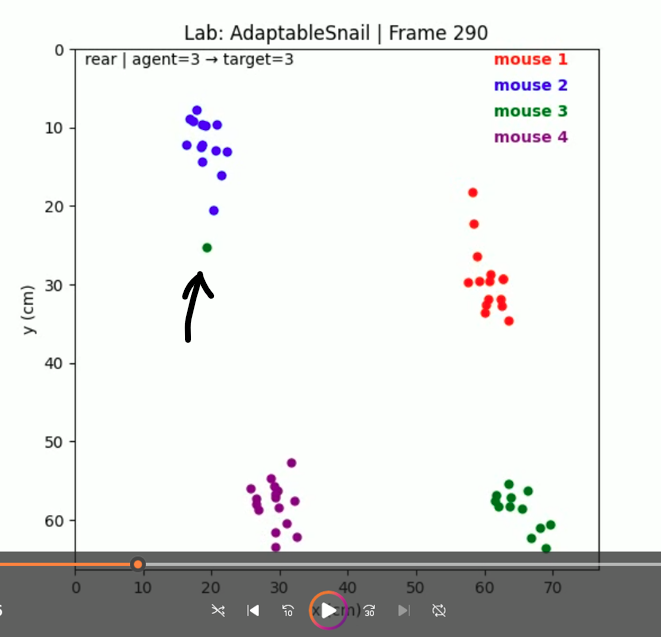

# Removed Outliers

In [27]:
def get_framewise_median(pvid, frame_idx, mouse_id):
    cols = pvid.columns

    # --- case 1: 3-level MultiIndex (mouse, body, coord) ---
    if cols.nlevels == 3:
        if mouse_id not in cols.get_level_values(0):
            return np.nan, np.nan
        sub = pvid.loc[frame_idx, mouse_id]  # → (bodypart, coord)

    # --- case 2: 2-level MultiIndex (body, coord) ---
    elif cols.nlevels == 2:
        sub = pvid.loc[frame_idx]           # 全 bodypart

    else:
        raise ValueError("Unexpected MultiIndex level count")

    # 各パーツの x, y
    xs = sub.xs("x", level=-1)
    ys = sub.xs("y", level=-1)

    # frame-wise の bodypart 中央値
    med_x = xs.median()
    med_y = ys.median()

    return med_x, med_y

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


🎬 Saved video: removed_outlier_AdaptableSnail_44566106.mp4
🎬 Saved video: removed_outlier_BoisterousParrot_402963089.mp4
🎬 Saved video: removed_outlier_CRIM13_363958890.mp4


KeyboardInterrupt: 

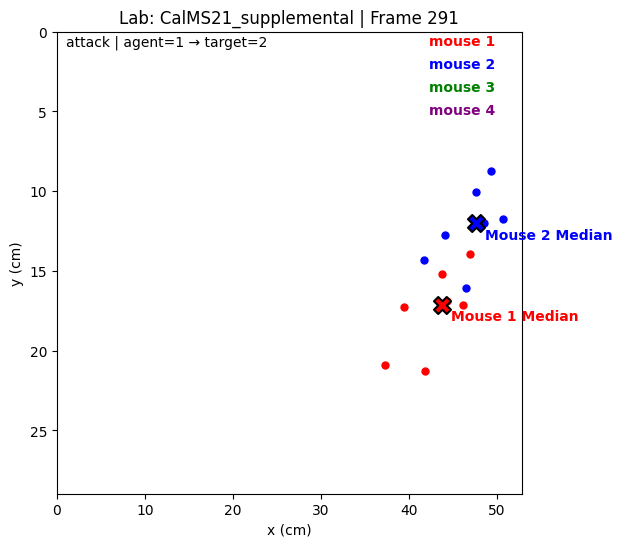

In [28]:
"""
Integrate meta data and tracking data
"""

for _, sample in tracking_samples_df.iterrows():

    # if sample['lab_id'] in lab_list:
    #     continue
        
    file_tr_path = (
        Path(CFG.train_tracking_path) 
        / sample["lab_id"] 
        / f"{sample['video_id']}.parquet"
    )
    file_annot_path = (
        Path(CFG.train_annotation_path) 
        / sample["lab_id"] 
        / f"{sample['video_id']}.parquet"   
    )
    
    annot_df = pd.read_parquet(file_annot_path)
    
    pvid = load_tracking(file_tr_path, sample.pix_per_cm_approx, CFG.num_frames, common_only=False)
    frame_actions = build_frame_action_dict(annot_df, CFG.num_frames)
    pvid = clean_outliers_by_framewise_median(pvid, dist_thresh=17.0, max_mouse=4)

    create_video_all_parts(
        pvid,
        frame_actions,
        lab_id=sample["lab_id"],
        output_path=f"removed_outlier_{sample['lab_id']}_{sample['video_id']}.mp4",
        fps=15
    )

    del pvid
    gc.collect()

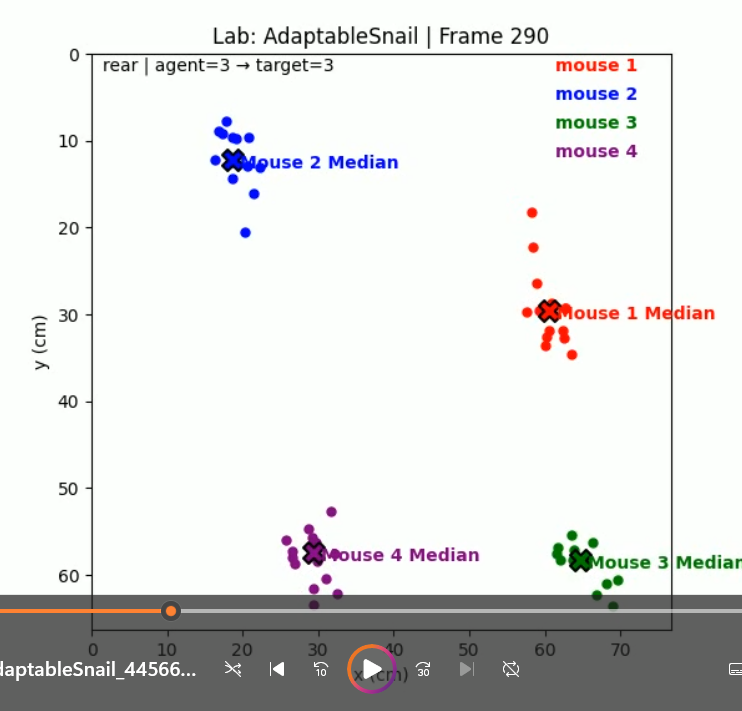